# Stage 2 EDA (LR Sweep: Baseline vs Elementwise)

Analysis-only notebook for Stage 2 runs (no launches). Reads `experiments/results.csv` and `logs/*.txt` to summarize baseline vs elementwise across LR multipliers.

## 0) Setup
- Activate venv before starting JupyterLab.

In [34]:
from pathlib import Path
import glob, re, json, os
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Detect project root: prefer PROJ_ROOT env, else repo root (parent if running from notebooks/)
cwd = Path.cwd().expanduser().resolve()
default_root = cwd.parent if cwd.name == 'notebooks' else cwd
PROJ_ROOT = Path(os.environ.get('PROJ_ROOT', default_root)).expanduser().resolve()
RESULTS_ALL = PROJ_ROOT / 'experiments' / 'results.csv'
RESULTS = PROJ_ROOT / 'experiments' / 'results_stage2.csv'
LOG_DIR = PROJ_ROOT / 'logs'

# If stage-specific results not found, fall back to aggregated results.csv
if not RESULTS.exists():
    if RESULTS_ALL.exists():
        RESULTS = RESULTS_ALL
    else:
        candidates = list(Path.cwd().rglob('experiments/results_stage2.csv'))
        if candidates:
            RESULTS = candidates[0].resolve()
            PROJ_ROOT = RESULTS.parent.parent
            LOG_DIR = PROJ_ROOT / 'logs'

print('Project root:', PROJ_ROOT)
print('Results:', RESULTS)
print('Logs dir:', LOG_DIR)

df = pd.read_csv(RESULTS) if RESULTS.exists() else pd.DataFrame()
df.head() if not df.empty else df


Project root: /home/milos/dev/ese-3060-project
Results: /home/milos/dev/ese-3060-project/experiments/results_stage2.csv
Logs dir: /home/milos/dev/ese-3060-project/logs


,run_id,date,git_commit,seed,attn_gate,gate_pos,gate_act,learning_rate,batch_size,device_batch_size,...,num_iterations,warmdown_iters,final_val_loss,best_val_loss,train_time_ms,ms_per_step,gpu_name,n_gpus,runpod_instance,notes
0,13cc37e4-4e5d-413a-a7e3-49b75a3bd31e,2025-12-07 16:42:44,bf6d1ff4b5e4ce7280e822ab33e90c4fb250e604,1337,none,sdpa,sigmoid,0.00360,512,64,...,800,1450,3.916023,3.916023,315838.543415,399.290194,NVIDIA A100 80GB PCIe,8,unknown,NaN
1,24f7a02e-917a-4a5b-a8f7-4ddd4ca00501,2025-12-07 16:50:42,bf6d1ff4b5e4ce7280e822ab33e90c4fb250e604,2337,none,sdpa,sigmoid,0.00360,512,64,...,800,1450,3.917398,3.917398,313247.016668,396.013928,NVIDIA A100 80GB PCIe,8,unknown,NaN
2,c49defbf-9e08-4aa8-adce-cbb1235ef9b0,2025-12-07 16:58:35,bf6d1ff4b5e4ce7280e822ab33e90c4fb250e604,1337,none,sdpa,sigmoid,0.00396,512,64,...,800,1450,3.895718,3.895718,315795.570135,399.235866,NVIDIA A100 80GB PCIe,8,unknown,NaN
3,82c60b9f-9641-4cff-bbd8-5300756af745,2025-12-07 17:06:18,bf6d1ff4b5e4ce7280e822ab33e90c4fb250e604,2337,none,sdpa,sigmoid,0.00396,512,64,...,800,1450,3.897076,3.897076,313421.765327,396.234849,NVIDIA A100 80GB PCIe,8,unknown,NaN
4,d4f28674-8b7e-4eec-b50f-a6f26d3de1f5,2025-12-07 17:14:04,bf6d1ff4b5e4ce7280e822ab33e90c4fb250e604,1337,none,sdpa,sigmoid,0.00432,512,64,...,800,1450,3.878806,3.878806,313280.065775,396.055709,NVIDIA A100 80GB PCIe,8,unknown,NaN


In [35]:
# EDA filters
NUM_ITER = 800
WARMUP_ITERS = 150
WARMDOWN_ITERS = None  # set to number to filter warmdown_iters
ATTN_GATES = ['none','elementwise']
SEEDS = [1337, 2337]  # optional; not strictly used in filters


## 1) Get Stage 2 runs

In [36]:
stage2 = df.copy()
stage2.head()


,run_id,date,git_commit,seed,attn_gate,gate_pos,gate_act,learning_rate,batch_size,device_batch_size,...,num_iterations,warmdown_iters,final_val_loss,best_val_loss,train_time_ms,ms_per_step,gpu_name,n_gpus,runpod_instance,notes
0,13cc37e4-4e5d-413a-a7e3-49b75a3bd31e,2025-12-07 16:42:44,bf6d1ff4b5e4ce7280e822ab33e90c4fb250e604,1337,none,sdpa,sigmoid,0.00360,512,64,...,800,1450,3.916023,3.916023,315838.543415,399.290194,NVIDIA A100 80GB PCIe,8,unknown,NaN
1,24f7a02e-917a-4a5b-a8f7-4ddd4ca00501,2025-12-07 16:50:42,bf6d1ff4b5e4ce7280e822ab33e90c4fb250e604,2337,none,sdpa,sigmoid,0.00360,512,64,...,800,1450,3.917398,3.917398,313247.016668,396.013928,NVIDIA A100 80GB PCIe,8,unknown,NaN
2,c49defbf-9e08-4aa8-adce-cbb1235ef9b0,2025-12-07 16:58:35,bf6d1ff4b5e4ce7280e822ab33e90c4fb250e604,1337,none,sdpa,sigmoid,0.00396,512,64,...,800,1450,3.895718,3.895718,315795.570135,399.235866,NVIDIA A100 80GB PCIe,8,unknown,NaN
3,82c60b9f-9641-4cff-bbd8-5300756af745,2025-12-07 17:06:18,bf6d1ff4b5e4ce7280e822ab33e90c4fb250e604,2337,none,sdpa,sigmoid,0.00396,512,64,...,800,1450,3.897076,3.897076,313421.765327,396.234849,NVIDIA A100 80GB PCIe,8,unknown,NaN
4,d4f28674-8b7e-4eec-b50f-a6f26d3de1f5,2025-12-07 17:14:04,bf6d1ff4b5e4ce7280e822ab33e90c4fb250e604,1337,none,sdpa,sigmoid,0.00432,512,64,...,800,1450,3.878806,3.878806,313280.065775,396.055709,NVIDIA A100 80GB PCIe,8,unknown,NaN


## 2) Aggregate metrics by config
- Groups by attn_gate and learning_rate
- Plots mean best val loss vs LR per gate

,attn_gate,learning_rate,runs,mean_best_val,std_best_val,mean_final_val,mean_ms_step
0,elementwise,0.00360,2,3.934880,0.001321,3.934880,424.375702
1,elementwise,0.00396,2,3.911479,0.001540,3.911479,420.346069
2,elementwise,0.00432,2,3.891968,0.001122,3.891968,419.602657
3,elementwise,0.00468,2,3.874321,0.002686,3.874321,423.020580
4,none,0.00360,2,3.916711,0.000972,3.916711,397.652061
5,none,0.00396,2,3.896397,0.000961,3.896397,397.735357
6,none,0.00432,2,3.879807,0.001414,3.879807,395.893805
7,none,0.00468,2,3.864021,0.000689,3.864021,398.617650


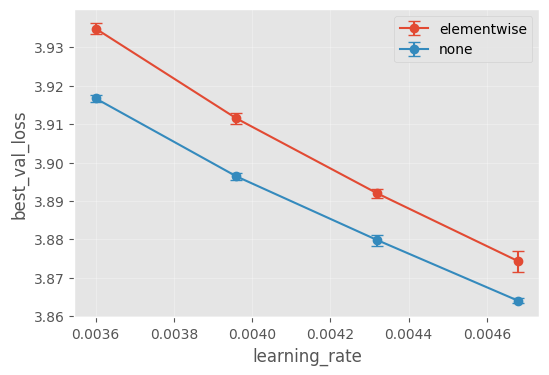

In [37]:
if not stage2.empty:
    group_cols = ['attn_gate','learning_rate']
    agg = stage2.groupby(group_cols).agg(
        runs=('run_id','count'),
        mean_best_val=('best_val_loss','mean'),
        std_best_val=('best_val_loss','std'),
        mean_final_val=('final_val_loss','mean'),
        mean_ms_step=('ms_per_step','mean'),
    ).reset_index()
    display(agg)
    if not agg.empty:
        fig, ax = plt.subplots(figsize=(6,4))
        for gate, sub in agg.groupby('attn_gate'):
            ax.errorbar(sub['learning_rate'], sub['mean_best_val'], yerr=sub['std_best_val'], marker='o', capsize=4, label=gate)
        ax.set_xlabel('learning_rate')
        ax.set_ylabel('best_val_loss')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.show()
else:
    print('No stage2 rows found; ensure results.csv exists and filters match.')

## 3) Parse val_loss curves from logs (first run per config)
Plots val_loss vs train_time for the first run of each (attn_gate, learning_rate) combo.

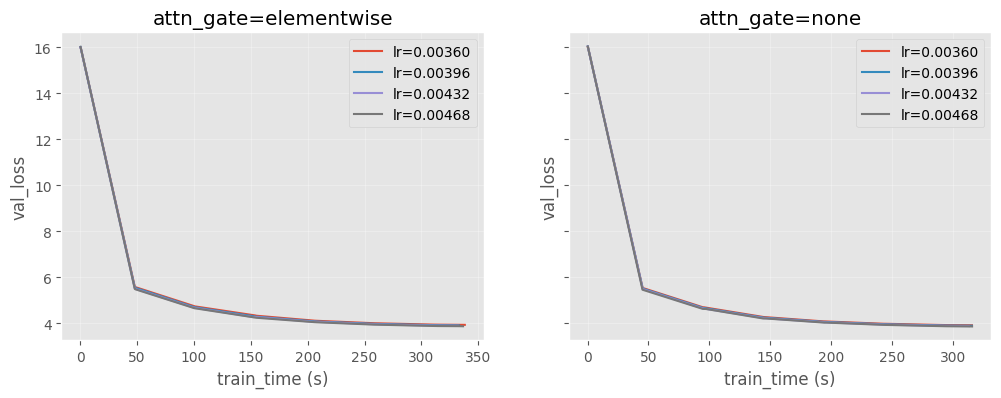

In [38]:
VAL_RE = re.compile(r"step:(\d+)/(\d+).*val_loss:([0-9.]+).*train_time:(\d+)ms")
rows = []
# Use LOG_DIR discovered above (falls back to repo root logs)
for path in LOG_DIR.glob('*.txt') if LOG_DIR.exists() else []:
    run_id = path.stem
    cfg = stage2[stage2['run_id']==run_id]
    if cfg.empty:
        continue
    cfg = cfg.iloc[0]
    with open(path) as f:
        for line in f:
            m = VAL_RE.search(line)
            if m:
                step = int(m.group(1))
                loss = float(m.group(3))
                t_ms = int(m.group(4))
                rows.append({
                    'run_id': run_id,
                    'step': step,
                    'val_loss': loss,
                    'train_time_ms': t_ms,
                    'attn_gate': cfg['attn_gate'],
                    'learning_rate': cfg['learning_rate'],
                })
curves = pd.DataFrame(rows)
if not curves.empty:
    fig, axes = plt.subplots(1, len(curves['attn_gate'].unique()), figsize=(12,4), sharey=True)
    if len(curves['attn_gate'].unique())==1:
        axes=[axes]
    for ax, (gate, sub) in zip(axes, curves.groupby('attn_gate')):
        for lr, sublr in sub.groupby('learning_rate'):
            sublr = sublr.sort_values('train_time_ms')
            ax.plot(sublr['train_time_ms']/1000.0, sublr['val_loss'], label=f"lr={lr:.5f}")
        ax.set_title(f"attn_gate={gate}")
        ax.set_xlabel('train_time (s)')
        ax.set_ylabel('val_loss')
        ax.legend()
        ax.grid(True, alpha=0.3)
    plt.show()
else:
    print('No matching logs parsed; ensure logs exist at', LOG_DIR, 'and filters match stage2 runs.')


In [ ]:
# Export parsed validation curves for stage2
if 'curves' in locals() and not curves.empty:
    export_path = PROJ_ROOT / 'experiments' / 'log_curves_stage2.csv'
    export_path.parent.mkdir(parents=True, exist_ok=True)
    curves.to_csv(export_path, index=False)
    print(f'Saved curves to {export_path}')
else:
    print('curves is empty; nothing to export.')
